# Injection Testing

Injection testing is a process of testing a signal detection algorithm by simulating what the signal would look like in context and then running the algorithm on it to determine if it is able to recover the signal and how accurately it can characterize it. ALIAS is a great candidate for this style of testing since it is trying to detect signals that are fairly easy to impliment.

In [8]:
import alias
import alias.injection as inj
import alias.continuum_normalization as cn

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.signal

import numpy as np
from astropy.io import fits

import random as rand

import tqdm.autonotebook as tqdm

In [3]:
plt.rcParams.update({'font.size': 10})

In [11]:
with open('../data/sample_star_urls', 'r') as f:
    urls = f.read().splitlines()

files = [ '../data/spectra/%s' %url.split('/')[-1] for url in urls ]

ds = alias.loadDataset(files)

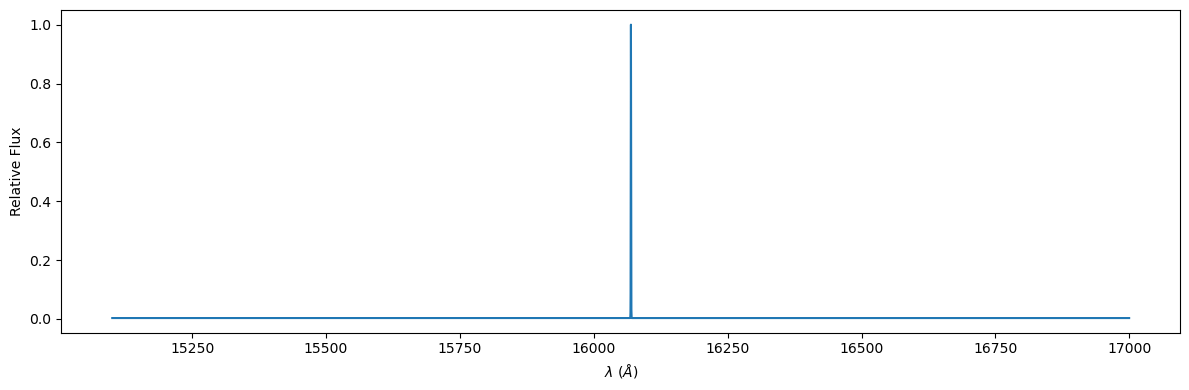

In [12]:
# Plot sample laser signature

lsf = inj.default_lsf

test_laser_signature = np.interp(np.array(range(len(ds.wave)))-4500, lsf.x, lsf.y)

plt.figure(figsize=(12,4))

plt.plot(ds.wave, test_laser_signature)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')

plt.tight_layout()

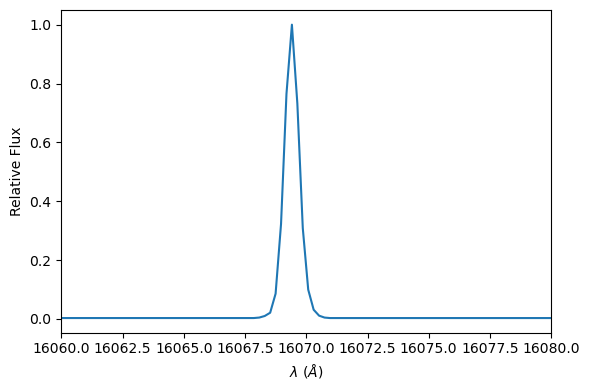

In [13]:
# Zoom in on signature

plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(6,4))

plt.plot(ds.wave, test_laser_signature)

plt.xlim(16060, 16080)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')

plt.tight_layout()

Text(0, 0.5, 'Relative Flux')

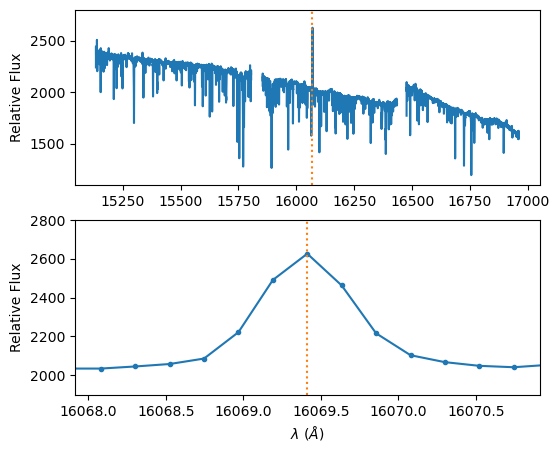

In [24]:
# Inject the signature


flux_injected = ds.flux[101] + 0.3 * np.nanmedian(ds.flux[101]) * test_laser_signature
ivar_injected = ds.ivar[101]

fig = plt.figure(figsize=(6,5))

gs = gridspec.GridSpec(2, 1, hspace=0.2)

ax1 = fig.add_subplot(gs[0])

ax1.plot(ds.wave, flux_injected)

ax1.plot([ds.wave[4500],]*2, (1100,2800), ls='dotted')

ax1.set_ylim(1100, 2800)

ax1.set_ylabel(r'Relative Flux')



ax2 = fig.add_subplot(gs[1])

ax2.plot(ds.wave, flux_injected, '.-')

ax2.plot([ds.wave[4500],]*2, (1900,2800), ls='dotted')

ax2.set_ylim(1900, 2800)
ax2.set_xlim(ds.wave[4500]-1.5, ds.wave[4500]+1.5)

ax2.set_xlabel(r'$\lambda$ ($\AA$)')
ax2.set_ylabel(r'Relative Flux')


In [ ]:
# Zoom in on signature again

plt.plot(ds.wave, flux_injected)

plt.xlim(16060, 16080)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')

plt.tight_layout()

In [ ]:
# Now start the detection process

# Continuum normalize the spectrum

flux_injected_norm, ivar_injected_norm, _ = cn.continuum_normalize((flux_injected, ), (ivar_injected))
flux_injected_norm = flux_injected_norm[0]
ivar_injected_norm = ivar_injected_norm[0]

plt.figure(figsize=(12,4))

plt.plot(ds.wave, flux_injected_norm)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')

plt.tight_layout()

In [ ]:
plt.plot(ds.wave, flux_injected_norm)

plt.xlim(16060, 16080)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')

plt.tight_layout()

In [ ]:
peaks = scipy.signal.find_peaks(flux_injected_norm, height = 1.1)[0]

recovered_wavelength = ds.wave[peaks[0]]
recovered_flux = flux_injected_norm[peaks[0]] - 1

print('Recovered Wavelength: %s' %recovered_wavelength)
print('Recovered Amplitude: %s' %recovered_flux)

In [ ]:
print('Delta lambda: %s' %(recovered_wavelength - ds.wave[4500]))
print('Delta flux: %s' %(recovered_flux - 0.3))

In [ ]:
# Implement Injection Testing Framework

def create_laser_signature(wave, lsf, idx):
    line = np.interp(np.array(range(len(wave)))-idx, lsf.x, lsf.y)
    return line

def injection_test(ds, lsf, detector, count, min_amp, max_amp):
    results = []

    for i in tqdm.trange(count):
        
        spec = rand.randrange(len(ds.flux))
        valid_idx = np.nonzero(~np.isnan(ds.flux[spec]))[0]
        idx_int = np.random.choice(valid_idx)
        idx = idx_int + np.random.uniform(-0.5, 0.5)
        wave = np.interp(idx, range(len(ds.wave)), ds.wave)
        amp = np.random.uniform(min_amp, max_amp)

        nflux = np.copy(ds.flux[spec])
        nflux += create_laser_signature(ds.wave, lsf, idx)*amp
        
        detections = detector(ds.wave, nflux, ds.ivar[spec])

        if len(detections) == 0:
            results.append((spec, idx, amp, 0, 0, 0, 0))
            continue

        detection_wavelengths = detections[:,0]
        detection_amplitudes = detections[:,1]

        detec_id = np.argmin(np.abs(detection_wavelengths - wave))
        delta_wave = detection_wavelengths[detec_id] - wave

        if np.abs(delta_wave) > 1:
            results.append((spec, idx, amp, 0, 0, 0, len(detections)))
            continue
        
        delta_flux = detection_amplitudes[detec_id] - amp
        results.append((spec, idx, amp, 1, delta_wave, delta_flux, len(detections) - 1))

    return np.array(results, dtype=float)

# Result structure: Spectrum id, injected wavelength, injected flux, detected?, delta wavelength, delta flux, num other detections
        

In [ ]:
# Run detector

median_flux = np.nanmedian(cn.continuum_normalize(ds.flux, ds.ivar)[0], axis=0)

In [ ]:
plt.figure(figsize=(6,3))

plt.plot(ds.wave, median_flux, label='Median Continuum-Normalized Spectrum')

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')

plt.legend()

plt.tight_layout()

In [ ]:
n = 5
f_residual = cn.continuum_normalize((ds.flux[n], ), (ds.ivar[n]))[0][0] - median_flux

plt.figure(figsize=(6,3))

plt.plot(ds.wave, f_residual, label='Median Continuum-Normalized Spectrum')
plt.ylim(-0.4, 0.4)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')

plt.tight_layout()

In [ ]:
def test_detector(wave, flux, ivar):
        
    flux_norm_res = cn.continuum_normalize((flux, ), (ivar))[0][0] - median_flux
    peaks = scipy.signal.find_peaks(flux_norm_res, height = 0.05)[0]
    wavelengths = wave[peaks]
    amplitudes = flux_norm_res[peaks]
    return np.array((wavelengths, amplitudes)).T

In [ ]:
features = test_detector(ds.wave, ds.flux[0], ds.ivar[0])

plt.figure(figsize=(6,3))

plt.plot(ds.wave, ds.flux[0])
plt.plot(features[:,0], ds.flux[0][np.array(np.interp(features[:,0], ds.wave, range(len(ds.wave))), dtype=int)], '.', color='red')

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')

_ = plt.tight_layout()

In [ ]:
results = injection_test(ds, inj.default_lsf, test_detector, 5000, 0.01, 0.5)

In [ ]:
# Now interpret results

print('Efficiency: %s%%' %(100*sum(results[:,3])/len(results)))
print('Other Detections: %s/spectrum' %np.mean(results[:,6]))

In [ ]:
def show_result(ds, lsf, detector, result):    
    plt.figure(figsize=(12,4))
    spec = int(result[0])
    flux_inj = ds.flux[spec] + create_laser_signature(ds.wave, lsf, result[1]) * result[2]
    wave = np.interp(result[1], range(len(ds.wave)), ds.wave)

    detections = detector(ds.wave, flux_inj, ds.ivar[spec])
    
    plt.plot(ds.wave, flux_inj, label='Injected Spectrum')
    plt.plot(ds.wave, ds.flux[spec], label='Original Spectrum')
    plt.scatter(detections[:,0], detections[:,1] + 1)

    plt.xlim(wave - 15, wave + 15)
        
    plt.xlabel(r'$\lambda$ ($\AA$)')
    plt.ylabel(r'Relative Flux')
    
    plt.tight_layout()

In [ ]:
show_result(ds, inj.default_lsf, test_detector, results[47])

In [ ]:
_ = plt.hist(results[results[:,3] > 0.5,4], bins=30)

plt.xlabel('$\Delta\lambda$ ($\AA$)')
plt.ylabel('Number of Detections')

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure()

gs = gridspec.GridSpec(1, 2, wspace=0)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.hist(results[results[:,3] > 0.5,4], bins=60)

ax1.set_ylim(0, 1300)
ax1.set_xlim(-1.2, 1.2)

ax1.set_xlabel('$\Delta\lambda$ ($\AA$)')
ax1.set_ylabel('Number of Detections')

ax2.hist(results[results[:,3] > 0.5,5], bins=60)
ax2.set_ylim(0, 1300)
ax2.set_yticks([])

ax2.set_xlabel('$\Delta Flux$')

fig.set_figwidth(6)
fig.set_figheight(3)



In [ ]:
_ = plt.hist(results[results[:,3] > 0.5,5], bins=30)

plt.xlabel('$\Delta$Flux')
plt.ylabel('Number of Detections')

In [ ]:
bins = np.linspace(0, 0.5, 30)
all = np.histogram(results[:,2], bins=bins)[0]
detected = np.histogram(results[results[:,3] > 0.5,2], bins=bins)[0]

plt.figure(figsize=(6,4))

plt.plot(bins[:-1], 100*detected/all)

plt.xlabel('LASER Flux (Fraction of Star Flux)')
_ = plt.ylabel(r'Efficiency (%)')

In [ ]:
plt.figure(figsize=(12,4))
bins = np.linspace(np.min(ds.wave), np.max(ds.wave), 300)
all = np.histogram(ds.wave[np.array(results[:,1], dtype=int)], bins=bins)[0]
detected = np.histogram(ds.wave[np.array(results[results[:,3] > 0.5,1], dtype=int)], bins=bins)[0]

plt.plot(bins[:-1], detected/all)

plt.xlabel('$\lambda$ ($\AA$)')
plt.ylabel(r'Efficiency (%)')

In [ ]:
plt.figure(figsize=(12,4))
plt.hist2d(ds.wave[np.array(results[results[:,3] > 0.5,1],dtype=int)], results[results[:,3] > 0.5,4], bins=(80, 40))
plt.xlabel('$\lambda$ ($\AA$)')
plt.ylabel('$\Delta\lambda$ ($\AA$)')

In [ ]:
plt.figure(figsize=(12,4))
plt.scatter(ds.wave[np.array(results[results[:,3] > 0.5,1],dtype=int)], results[results[:,3] > 0.5,4], s=3)
plt.xlabel('$\lambda$ ($\AA$)')
plt.ylabel('$\Delta\lambda$ ($\AA$)')

## Retrieving Accurate Wavelengths

In [ ]:
# Create Test Injected Signal to Measure

lsf = inj.default_lsf
test_laser_signature = np.interp(np.array(range(len(ds.wave)))-4500.5, lsf.x, lsf.y)

flux_injected = ds.flux[101] + 0.3 * test_laser_signature
ivar_injected = ds.ivar[101]

flux_injected_norm, ivar_injected_norm, _ = cn.continuum_normalize((flux_injected, ), (ivar_injected))
flux_injected_norm = flux_injected_norm[0]
ivar_injected_norm = ivar_injected_norm[0]

fig, ax = plt.subplots()

ax.plot(ds.wave, flux_injected_norm)

ax.set_xlabel(r'$\lambda$ ($\AA$)')
ax.set_ylabel(r'Relative Flux')

fig.set_figwidth(6)
fig.set_figheight(3)

fig.tight_layout()

In [ ]:
min = 4490
max = 4511

peak_w = ds.wave[min:max]
peak_f = flux_injected_norm[min:max]
peak_i = ivar_injected_norm[min:max]

fig, ax = plt.subplots()

ax.errorbar(peak_w, peak_f, yerr=peak_i**-0.5*10, fmt='.')

ax.set_xlabel(r'$\lambda$ ($\AA$)')
ax.set_ylabel(r'Relative Flux')

fig.set_figwidth(6)
fig.set_figheight(3)

fig.tight_layout()

In [ ]:
plt.plot(peak_f)
plt.plot(inj.default_lsf.x, inj.default_lsf.y)
fit = np.interp(range(len(peak_f)), inj.default_lsf.x + 10.5, 0.3*np.array(inj.default_lsf.y)) + 1
plt.plot(fit)

In [ ]:
def chi_lsf(y, y_err, lsfx, lsfy, amp, mean):
    lsf = np.interp(range(len(y)), lsfx + mean, amp*lsfy)
    return np.sum(((y - lsf)/y_err)**2)

def get_properties(wave, flux, ivar, amp):
    mean_idx = np.linspace(len(wave)/2 - 0.5, len(wave)/2 + 0.5, 20)

    err_mean = [ chi_lsf(flux, ivar**-0.5, inj.default_lsf.x, np.array(inj.default_lsf.y), amp, mean) for mean in mean_idx ]

    mean_idx = mean_idx[np.argmin(err_mean)]
    mean = np.interp(mean_idx, range(len(wave)), wave)

    amps = np.linspace(0, 1, 30)
    err_amp = [ chi_lsf(flux, ivar**-0.5, inj.default_lsf.x, np.array(inj.default_lsf.y), amp, mean_idx) for amp in amps ]

    amp = amps[np.argmin(err_amp)]

    return (mean, amp)

get_properties(peak_w, peak_f, peak_i, 0.3)

In [ ]:
center = peak_w[int(len(peak_w)/2)]
width = peak_w[int(len(peak_w)/2)+1] - center
chi = np.array([ [ chi_lsf(peak_f, peak_i**-0.5, inj.default_lsf.x, np.array(inj.default_lsf.y), amp, mean) for amp in np.linspace(0.2, 0.4, 30) ] for mean in np.linspace(len(peak_w)/2 - 0.5, len(peak_w)/2 + 0.5, 30) ])

print(len(peak_w)/2)

print(np.argmin(chi))

plt.imshow(chi)

In [ ]:
def chi_lsf(y, y_err, lsfx, lsfy, amp, mean):
    lsf = np.interp(range(len(y)), lsfx + mean, amp*lsfy)
    return np.sum(((y - lsf)/y_err)**2)

def get_properties(wave, flux, ivar, amp):
    mean_idx = np.linspace(len(wave)/2 - 1, len(wave)/2, 64)

    err_mean = [ chi_lsf(flux, ivar**-0.5, inj.default_lsf.x, np.array(inj.default_lsf.y), amp, mean) for mean in mean_idx ]

    mean_idx = mean_idx[np.argmin(err_mean)]
    mean = np.interp(mean_idx, range(len(wave)), wave)

    amps = np.linspace(amp*0.7, amp*1.4, 64)
    err_amp = [ chi_lsf(flux, ivar**-0.5, inj.default_lsf.x, np.array(inj.default_lsf.y), a, mean_idx) for a in amps ]

    amp = amps[np.argmin(err_amp)]
    return (mean, amp)

def accurate_detector(wave, flux, ivar):
        
    flux_norm_res = cn.continuum_normalize((flux, ), (ivar))[0][0] - median_flux
    peaks = scipy.signal.find_peaks(flux_norm_res, height = 0.05)[0]

    amplitudes = flux_norm_res[peaks]
    amplitudes_corrected = []
    wavelengths = []

    for peak in peaks:
        peak_w = wave[peak-10:peak+11]
        peak_f = flux_norm_res[peak-10:peak+11]
        nan_filter = np.isnan(peak_f) | np.isnan(peak_w) | np.isnan(peak_i)
        wl, amp = get_properties(peak_w[~nan_filter], peak_f[~nan_filter], peak_i[~nan_filter], flux_norm_res[peak])
        wavelengths.append(wl)
        amplitudes_corrected.append(amp)
    
    return np.array((wavelengths, amplitudes_corrected)).T

In [ ]:
accurate_detector(ds.wave, flux_injected_norm, ivar_injected_norm)

In [ ]:
results = injection_test(ds, inj.default_lsf, accurate_detector, 5000, 0.01, 0.5)

In [ ]:
print('Efficiency: %s%%' %(100*sum(results[:,3])/len(results)))
print('Other Detections: %s/spectrum' %np.mean(results[:,6]))

In [ ]:
bins = np.linspace(0, 0.5, 30)
all = np.histogram(results[:,2], bins=bins)[0]
detected = np.histogram(results[results[:,3] > 0.5,2], bins=bins)[0]

plt.figure(figsize=(6,4))

plt.plot(bins[:-1], 100*detected/all)

plt.xlabel('LASER Flux (Fraction of Star Flux)')
_ = plt.ylabel(r'Efficiency (%)')

In [ ]:


fig = plt.figure()

gs = gridspec.GridSpec(1, 2, wspace=0)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.hist(results[results[:,3] > 0.5,4], bins=240)

ax1.set_ylim(0, 4000)
ax1.set_xlim(-0.3, 0.3)

ax1.set_xlabel('$\Delta\lambda$ ($\AA$)')
ax1.set_ylabel('Number of Detections')

ax2.hist(results[results[:,3] > 0.5,5], bins=60)
ax2.set_ylim(0, 4000)
ax2.set_yticks([])

ax2.set_xlabel('$\Delta Flux$')

fig.set_figwidth(6)
fig.set_figheight(3)

In [ ]:
def show_result(ds, lsf, detector, result):    
    plt.figure(figsize=(12,4))
    spec = int(result[0])
    flux_inj = ds.flux[spec] + create_laser_signature(ds.wave, lsf, result[1]) * result[2]
    wave = np.interp(result[1], range(len(ds.wave)), ds.wave)

    detections = detector(ds.wave, flux_inj, ds.ivar[spec])
    
    plt.plot(ds.wave, flux_inj, label='Injected Spectrum')
    plt.plot(ds.wave, ds.flux[spec], label='Original Spectrum')
    plt.scatter(detections[:,0], detections[:,1] + 1)
    plt.scatter(wave, result[2] + 1)

    plt.xlim(wave - 15, wave + 15)
        
    plt.xlabel(r'$\lambda$ ($\AA$)')
    plt.ylabel(r'Relative Flux')
    
    plt.tight_layout()

In [ ]:
show_result(ds, inj.default_lsf, test_detector, results[1556])

In [ ]:
print(np.argwhere(results[:,5] > 0.15))